# LFPCA on Visual Grating

#### Visual Grating Task

    *Task design
    Monkey was sitting with head fixed. His arm motion was also restrained. 
    ECoG data and eye position were recorded. There was a monitor in front of the monkey. 
    Grating pattern that moves in eight direction was presented on the screen. 
    There was no fixation required. Blank and stimulus pattern were switched alternatively every 2 sec. 
    Stimulus events can be decoded from 129th channel by analog value. 
    ECoG data were sampled at 1KHz.

    *Data Format
    A. ECoG_chN.mat
    ECoGData_chN: ECoG signal (μV) recorded from electrodeN (1‐128), sampled at 1kHZ.
    The Location of electrode is documented in "K2.png".

    B. ECoG_time.mat
    ECoGTime: ECoGTime is a one row-vector contains Time-stamps with the same length as ECoGData_chN.

    C. Event.mat
    EventData: EventData is a one row-vector contains analog input.
    -Analog input format
          Ain indicates event time.
          [   0- 100] : preparation time before experiment
          [ 300- 400] : ITI
          [ 650- 750] : Stimulus 1 ( 45 degree)
          [ 950-1050] : Stimulus 2 ( 90 degree)
          [1300-1400] : Stimulus 3 (135 degree)
          [1600-1700] : Stimulus 4 (180 degree)
          [1950-2050] : Stimulus 5 (225 degree)
          [2250-2350] : Stimulus 6 (270 degree)
          [2600-2700] : Stimulus 7 (315 degree)
          [2900-3000] : Stimulus 8 (360 degree)
    EventTime: EventTime is a one row-vector contains corresponding time-stamp.



In [1]:
import sys
sys.path.append('/Users/Lauren/Voytek/spectralCV')

In [17]:
%matplotlib inline

# imports
from scv_funcs import access_nt as asc
import numpy as np
import scipy as sp
import scipy.io as io
import scipy.signal as sig
import matplotlib.pyplot as plt
import pandas as pd
import h5py

import neurodsp as ndsp
from fooof import FOOOFGroup
from scv_funcs import lfpca

#load data from h5 
h5_file = '../Voytek/scv.h5'

### Extracting data information based on events

In [39]:
data_path = "/Users/Lauren/Data/NeuroTycho/VisualGrating/20100723S1_VGT_K2_KazuhitoTakenaka-ToruYanagawa_mat_ECoG128-Event3/"

# setting event data into pandas dataframe
matfile = io.loadmat(data_path + 'Event', squeeze_me=True)
EventData = matfile['EventData']
EventIndex = matfile['EventIndex']

df = pd.DataFrame(data = [EventData, EventIndex]).T
df = df.rename(columns={0: 'EventData', 1: 'EventIndex'})

In [53]:
# blanks
ITI = df[(df['EventData'] > 300) & (df['EventData'] < 400)]

In [55]:
# different stimulations 1 to 8 according to the boundary edges
edges = [(650,750), (950,1050), (1300,1400), (1600,1700), (1950,2050), (2250,2350), (2600,2700), (2900,3000)]
stims = np.empty((8,),dtype=object)
for i,edge in enumerate(edges):
    lower = edge[0]
    upper = edge[1]
    stims[i]= df[(df['EventData'] > lower) & (df['EventData'] < upper)]

In [57]:
# accessing data
data_path = "/Users/Lauren/Data/NeuroTycho/VisualGrating/20100723S1_VGT_K2_KazuhitoTakenaka-ToruYanagawa_mat_ECoG128-Event3/"

In [80]:
# getting session data
session = 0
chan = np.arange(1,129).tolist()
# chan = [1]
data = asc.get_ECoG(data_path, session, chan)

In [83]:
# ITI blank data
ITIdata = np.vstack((data[0][ITI['EventIndex']], data[1][ITI['EventIndex']]))
for c in range(2,128):
    ITIdata = np.vstack((ITIdata, data[c][ITI['EventIndex']]))

In [86]:
# different stim data
def get_stimdata(num):
    stimdata = np.vstack((data[0][stims[num]['EventIndex']], data[1][stims[num]['EventIndex']]))
    for c in range(2,128):
        stimdata = np.vstack((stimdata, data[c][stims[num]['EventIndex']]))

In [84]:
# example of using LFPCA
fs = 1000
analysis_param = {'nperseg': 1000,
                 'noverlap': 0,
                 'spg_outlierpct': 2.,
                 'max_freq':200}

# initialize object with data and parameters
vg_lfpca = lfpca.LFPCA(analysis_param)
vg_lfpca.populate_ts_data(ITIdata, fs)

# compute all spectral attributes
vg_lfpca.compute_all_spectral()

In [15]:
# compute KS-test fit against null exponential hypothesis
vg_lfpca.compute_KS_expfit() # this takes a few minutes

AttributeError: 'LFPCA' object has no attribute 'ks_pvals'

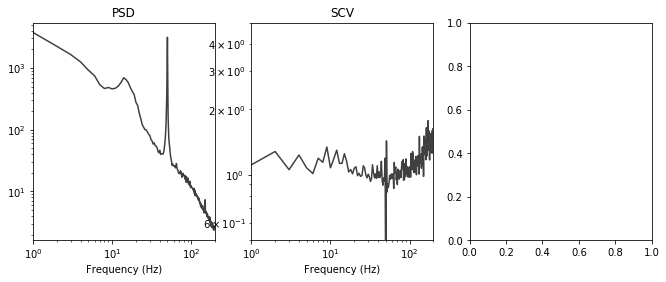

In [85]:
plot_chan = 2

plt.figure(figsize=(15,4))
vg_lfpca.plot_spectral(plot_mean=False, plot_chan=plot_chan)

# plot_freqs = [7,55,100]
# plt.figure(figsize=(15,4))
# for i,f in enumerate(plot_freqs):
#     plt.subplot(1,3,i+1)
#     vg_lfpca.plot_expfit(chan=plot_chan, freq_ind=f)

plt.tight_layout()